### Configure the Spark Context

In [1]:
def setupSpark():
  # Spark needs to run with Java 8 ... 
  !pip install -q findspark
  !apt-get install openjdk-8-jdk-headless > /dev/null
  !echo 2 | update-alternatives --config java > /dev/null
  !wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
  !tar xf spark-3.1.2-bin-hadoop3.2.tgz
  # !java -version
  import os, findspark
  os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-8-openjdk-amd64'
  os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"
  # !echo JAVA_HOME=$JAVA_HOME
  !pip install -q pyspark
  findspark.init()
  !pyspark --version


setupSpark()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 3.1.2
      /_/
                        
Using Scala version 2.12.10, OpenJDK 64-Bit Server VM, 1.8.0_362
Branch HEAD
Compiled by user centos on 2021-05-24T04:27:48Z
Revision de351e30a90dd988b133b3d00fa6218bfcaba8b8
Url https://github.com/apache/spark
Type --help for more information.


In [2]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
    
spark = SparkSession\
        .builder\
        .master('local[*]')\
        .getOrCreate()
sc = spark.sparkContext
sc.setLogLevel("WARN")

## Read in Dataset

In [3]:
from pyspark.sql.functions import *

In [4]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
filePath = "drive/MyDrive/Colab Notebooks/video_info.parquet"
videos_df = spark.read.format("parquet").option("header","true").load(filePath)


In [27]:
# drop nans
videos_df = videos_df.na.drop(subset=["title"])

# Creator types

In [28]:
# split the 'creator_href' column and get creator types
split_col = split(videos_df['creator_href'], '/')
videos_df = videos_df.withColumn('creator_type', split_col.getItem(1))

# group by count and display
result_df = videos_df.groupBy("creator_type").count()
result_df.show()

+------------+------+
|creator_type| count|
+------------+------+
|       model| 13024|
|    pornstar| 26993|
|    channels|109182|
+------------+------+



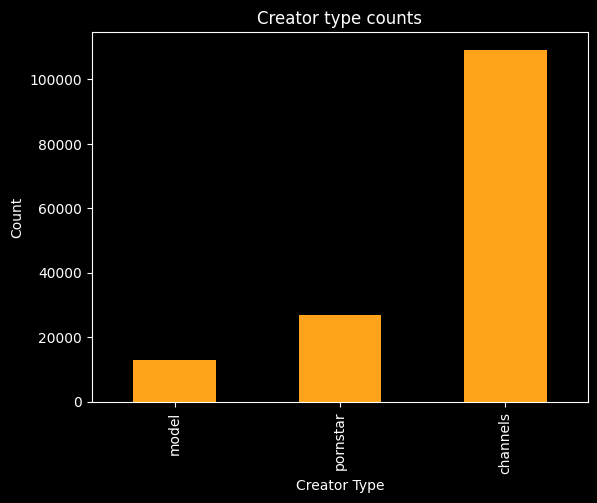

In [29]:
# Plot results
import matplotlib.pyplot as plt

# Convert Spark DataFrame to Pandas
pandas_df = result_df.toPandas()

# Plot
plt.style.use('dark_background')
pandas_df.plot(kind='bar', x='creator_type', y='count', legend=False, color='#ffa31a')
plt.xlabel('Creator Type')
plt.ylabel('Count')
plt.title('Creator type counts')
plt.savefig('./creator_type_counts.png', dpi=300)

# Word frequencies in video titles

In [30]:
# split video titles into words
split_col = split(videos_df['title'], ' ')

# create new dataframe with one word per row
words_df = videos_df.withColumn('title_word', explode(split_col))

# count words and display
word_counts = words_df.groupBy('title_word').count()
word_counts.show()

+----------+-----+
|title_word|count|
+----------+-----+
|    Taking|  345|
|   Amateur| 2322|
|    outfit|   65|
|      foxy|    8|
|         K|   28|
|      Faye|   34|
|   Amazing|  458|
|      some|  605|
|  strap-on|   51|
|     Bucks|   12|
|     Tyler|  156|
|   barrier|    1|
|    LITTLE|   44|
|     those|   19|
| librarian|    4|
|      Maze|   34|
|        By| 2549|
|        3P|    3|
|    Volume|   11|
|    Heaven|   74|
+----------+-----+
only showing top 20 rows



In [31]:
from pyspark.sql.types import StringType

In [32]:
# text cleaning function
def clean_text(text):
  if text:
    punc = '!"#$&\'()*+,.:;<=>?@[\\]^_`{|}~-'
    lowercased_str = text.lower()
    for ch in punc:
        lowercased_str = lowercased_str.replace(ch, '')
    return lowercased_str
  else:
    return ''
# register the UDF
clean_text_udf = udf(clean_text, StringType())

# apply to the video titles and store in new column
videos_df = videos_df.withColumn('cleaned_title', clean_text_udf(videos_df['title']))


In [33]:
# example
videos_df[['cleaned_title']].show(5)

+--------------------+
|       cleaned_title|
+--------------------+
|hot latina sativa...|
|jazzmine  the poo...|
|first time with a...|
|2 big tit milfs s...|
|latina student ru...|
+--------------------+
only showing top 5 rows



In [34]:
# now, remove stopwords
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stopwords = stopwords.words('english') + ['00000000', '000000']

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [35]:
# function to remove stopwords from clean title
def remove_stopwords(text):
    if text:
      words = text.split(' ')
      filtered_words = [word for word in words if word not in stopwords]
      return ' '.join(filtered_words)
    return ''

# register the UDF
remove_stopwords_udf = udf(remove_stopwords, StringType())

# apply to the cleaned titles
videos_df = videos_df.withColumn('double_cleaned_title', remove_stopwords_udf(videos_df['cleaned_title']))

In [36]:
# example
videos_df.select('double_cleaned_title').show(5)

+--------------------+
|double_cleaned_title|
+--------------------+
|hot latina sativa...|
|jazzmine  pool pa...|
|first time americ...|
|2 big tit milfs s...|
|latina student ru...|
+--------------------+
only showing top 5 rows



In [41]:
# filter out empty strings
videos_df = videos_df.filter(videos_df['double_cleaned_title'] != '')

In [42]:
# split cleaned video titles into words
split_col = split(videos_df['double_cleaned_title'], ' ')

# create new dataframe with one word per row
words_df = videos_df.withColumn('title_word', explode(split_col))

# count words and display
word_counts = words_df.groupBy('title_word').count()
word_counts.show()

+--------------+-----+
|    title_word|count|
+--------------+-----+
|        outfit|  105|
|          foxy|   71|
|        freaks|   40|
|       barrier|    1|
|     librarian|    9|
|           art|   94|
|  masturbating| 1120|
|        tweety|    2|
|    strawberry|   17|
|     stilettos|   22|
|exgirlfriendp5|    1|
|           bmb|    1|
|         hanna|   43|
|        online|   83|
|         spoil|    4|
|          hope|   53|
|         trina|   16|
|         cures|   14|
|          wank|   93|
|        teener|    3|
+--------------+-----+
only showing top 20 rows



In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
# store word counts in pandas
word_counts_df = word_counts.toPandas()

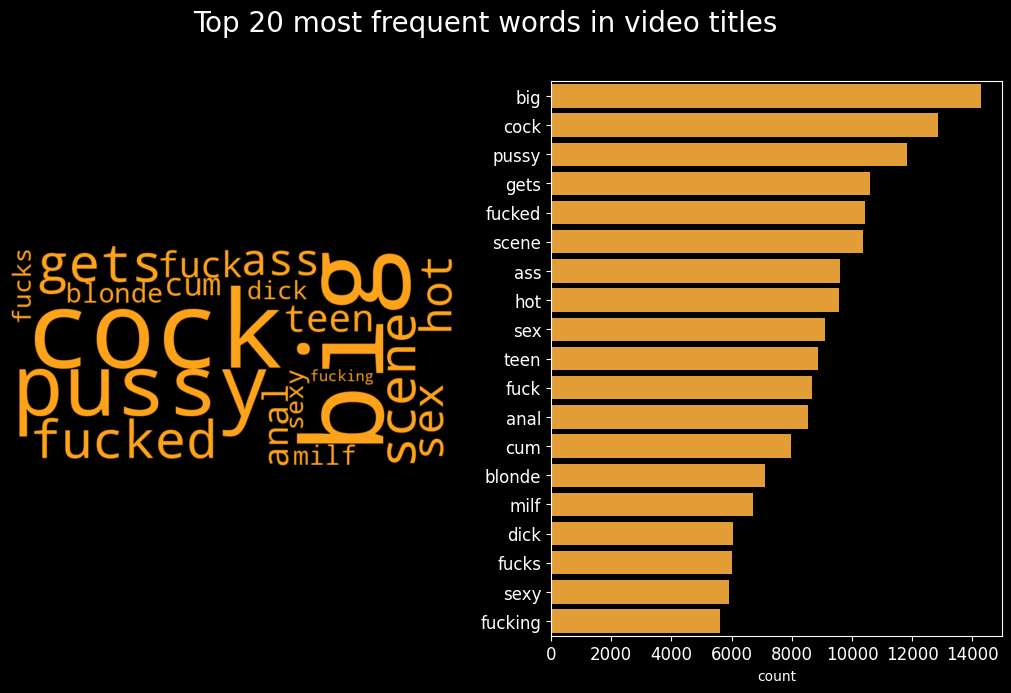

In [71]:
# plot frequencies and wordcloud
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2*6.4, 1.5*4.8))

# top 20 frequent words in video titles
word_counts_df = word_counts_df.nlargest(20, 'count')
word_counts_df = word_counts_df[word_counts_df['title_word'] != '']

# wordcloud
from wordcloud import WordCloud
word_freq_dict = dict(zip(word_counts_df['title_word'], word_counts_df['count']))

wordcloud = WordCloud(width=800, height=400, color_func=lambda *args, **kwargs: '#ffa31a').generate_from_frequencies(word_freq_dict)
ax1.imshow(wordcloud, interpolation='bilinear')
ax1.axis('off')

# plot word frequencies
sns.barplot(x='count', y='title_word', data=word_counts_df, color = '#ffa31a', ax=ax2)
ax2.set_ylabel('')
ax2.tick_params(axis='y', labelsize='large')
ax2.tick_params(axis='x', labelsize='large')
fig.suptitle('Top 20 most frequent words in video titles ', fontsize=20)
fig.savefig('./word_frew_and_cloud_video_titles.png', dpi=300)